In [41]:
import torch
from transformers import AdamW
from utils import get_dataloaders, get_dataset, get_cm, show_cm
from model_utils import train_model, model_predict
from model import TweetModel
import gc
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score

In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
batch_size = 16

In [4]:
data = get_dataset()
tensor_dataloaders = get_dataloaders(data, batch_size)

Using custom data configuration default
Reusing dataset tweets_hate_speech_detection (C:\Users\Алексей\.cache\huggingface\datasets\tweets_hate_speech_detection\default\0.0.0\c32a982d8b2d6233065d820ac655454174f8aaa8faddc74979cf793486acd3b0)


In [5]:
torch.cuda.empty_cache()
gc.collect()

19

In [6]:
model = TweetModel(2)
optimizer_fn = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
loss_fn = torch.nn.CrossEntropyLoss()

In [8]:
y_pred, y_true = model_predict(model, tensor_dataloaders['test'], device)

In [9]:
cm = get_cm(y_pred, y_true)
show_cm(cm)

In [42]:
print(f'Accuracy before training: {accuracy_score(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))}')

Accuracy before training: 0.9820087609511889


In [10]:
num_epochs = 3
model, best_loss_dict, best_epoch, metrics = train_model(model,
                                                         optimizer_fn,
                                                         loss_fn,
                                                         num_epochs,
                                                         tensor_dataloaders,
                                                         device)

----------
Epoch 1/3
train: loss: 5.77e-06
validation: loss: 3.96e-06
saving best model
7m 16s
----------
Epoch 2/3
train: loss: 5.40e-08
validation: loss: 2.29e-07
saving best model
7m 19s
----------
Epoch 3/3
train: loss: 3.04e-06
validation: loss: 3.96e-07
7m 19s
Best epoch: 2
best_train_loss: 5.40e-08
best_val_loss: 2.29e-07


In [11]:
y_pred, y_true = model_predict(model, tensor_dataloaders['test'], device)

In [44]:
print(f'Accuracy after training: {accuracy_score(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))}')

Accuracy after training: 0.9820087609511889


In [12]:
cm2 = get_cm(y_pred, y_true)
show_cm(cm2)

In [32]:
precision = dict()
recall = dict()
average_precision = dict()
labels = []

for i in range(2):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], y_pred[:, i])
    labels.append('Precision-recall for class {0} (area = {1:0.4f})'
                  ''.format(i, average_precision[i]))


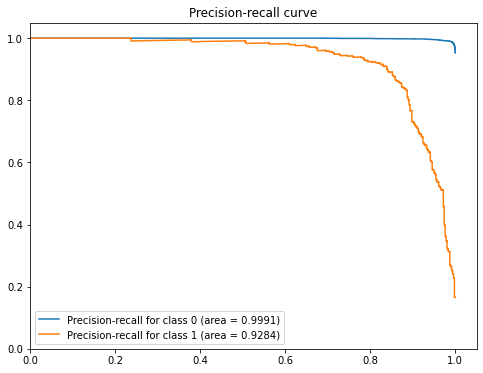

In [45]:
plt.figure(figsize=(8, 6))
plt.step(recall[0], precision[0])
plt.step(recall[1], precision[1])
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.title('Precision-recall curve')
plt.legend(labels)
plt.show()
